In [7]:
import pandas as pd
import numpy as np
# 加载Excel文件
xls = pd.ExcelFile("E:\\数学建模国赛2023选题\\C题\\第二题建模约束参数.xlsx")

# Preview the first few rows of each sheet to understand the structure and column names
sheet_names = xls.sheet_names

# Store previews of each sheet
sheet_previews = {}

for sheet in sheet_names:
    sheet_previews[sheet] = pd.read_excel(xls, sheet).head()

sheet_previews




{'Model_Params':            a         b   星期   分类名称
 0  84.277492  0.974480  星期三  水生根茎类
 1  81.092421  1.009424  星期三    花叶类
 2  14.822394  1.011291  星期三    花菜类
 3  25.241518  0.999187  星期三     茄类
 4  61.474034  1.000100  星期三    辣椒类,
 'Markup_Bounds':     分类名称  lower_bound  upper_bound
 0  水生根茎类    44.059830    96.064736
 1    花叶类    55.054544    97.460568
 2    花菜类    36.620075    83.754887
 3     茄类    43.469963   134.360511
 4    辣椒类    46.272717   148.951008,
 'Sales_Bounds':     分类名称  lower_bound  upper_bound
 0  水生根茎类      4.82050     91.51175
 1    花叶类    105.64975    289.32900
 2    花菜类      8.09800     79.35975
 3     茄类     12.86075     51.80800
 4    辣椒类     33.14950    151.92225,
 'Daily_Sales_Bounds':    lower_bound  upper_bound
 0    228.75775    650.33475}

In [8]:
# Import the optimization package and numpy for numerical operations
from pyswarm import pso
import numpy as np

# Helper function to round to 3 significant digits
def round_to_3(x):
    return round(x, 3 - int(np.floor(np.log10(abs(x)))) - 1)

# Function to run the optimization for a given day
def optimize_for_day(day):

    # Filter model parameters for the given day
    model_params_day = model_params_df[model_params_df['星期'] == day]
    a_values_day = model_params_day['a'].values.round(3)
    b_values_day = model_params_day['b'].values.round(3)

    # Define the objective function
    def objective(vars):
        x = vars[:6]
        y = vars[6:]
        return -np.sum(x * y)

    # Define the constraint function
    def constraints(vars):
        cons = []
        epsilon = 0.00001  # Small epsilon value for soft constraints

        # Add 6 model constraints (only for the given day)
        for i in range(6):
            cons.append(abs(vars[6+i] - a_values_day[i] * np.exp(b_values_day[i] * vars[i])) - epsilon)

        # Add 12 range constraints (6 for markup, 6 for sales)
        for i in range(6):
            cons.append(vars[i] - markup_lower_bound[i])
            cons.append(markup_upper_bound[i] - vars[i])
            cons.append(vars[6+i] - sales_lower_bound[i])
            cons.append(sales_upper_bound[i] - vars[6+i])

        # Add daily sales upper and lower bound constraints
        cons.append(daily_sales_upper_bound - np.sum(vars[6:]))
        cons.append(np.sum(vars[6:]) - daily_sales_lower_bound)

        return cons

    # Define lower and upper bounds for the variables
    lb = list(markup_lower_bound) + list(sales_lower_bound)
    ub = list(markup_upper_bound) + list(sales_upper_bound)

    # Run the optimization using Particle Swarm Optimization
    xopt, fopt = pso(objective, lb, ub, f_ieqcons=constraints)

    return xopt, -fopt

# Load the constraints and model parameters and round to 3 significant digits
model_params_df = pd.read_excel(xls, 'Model_Params')
markup_bounds_df = pd.read_excel(xls, 'Markup_Bounds')
sales_bounds_df = pd.read_excel(xls, 'Sales_Bounds')
daily_sales_bounds_df = pd.read_excel(xls, 'Daily_Sales_Bounds')

markup_lower_bound = markup_bounds_df['lower_bound'].apply(round_to_3).values
markup_upper_bound = markup_bounds_df['upper_bound'].apply(round_to_3).values

sales_lower_bound = sales_bounds_df['lower_bound'].apply(round_to_3).values
sales_upper_bound = sales_bounds_df['upper_bound'].apply(round_to_3).values

daily_sales_lower_bound = round_to_3(daily_sales_bounds_df.loc[0, 'lower_bound'])
daily_sales_upper_bound = round_to_3(daily_sales_bounds_df.loc[0, 'upper_bound'])

# Days of the week
days_of_week = ['星期一', '星期二', '星期三', '星期四', '星期五', '星期六', '星期日']

# Run the optimization for each day and store the results
optimization_results = {}

for day in days_of_week:
    xopt, fopt = optimize_for_day(day)
    optimization_results[day] = {
        'Optimized Variables': xopt,
        'Optimized Objective': fopt
    }

optimization_results



Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: Swarm best position change less than 1e-08
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100
Stopping search: maximum iterations reached --> 100


{'星期一': {'Optimized Variables': array([ 96.0798962 ,  97.5       ,  83.8       , 134.        ,
         149.        ,  89.8       ,  39.09098817, 289.        ,
          52.26554345,  51.8       , 152.        ,  65.80467266]),
  'Optimized Objective': 71811.67023188081},
 '星期二': {'Optimized Variables': array([ 96.1       ,  97.5       ,  83.79995915, 134.        ,
         149.        ,  89.8       ,  91.5       , 289.        ,
          24.02559479,  51.8       , 152.        ,  41.67440508]),
  'Optimized Objective': 72315.55543738788},
 '星期三': {'Optimized Variables': array([ 96.1       ,  97.5       ,  83.8       , 134.        ,
         149.        ,  89.8       ,  38.37331117, 289.        ,
          79.4       ,  51.79999449, 152.        ,  39.42669432]),
  'Optimized Objective': 71648.61161525479},
 '星期四': {'Optimized Variables': array([ 96.09975963,  97.49999995,  83.79945524, 133.99761614,
         149.        ,  89.8       ,  89.91375191, 227.02819734,
          77.28110494,  

In [9]:
import pandas as pd

# 创建一个空的DataFrame来存储结果
columns = ['Day', 'Category', 'Optimized Markup Rate (%)', 'Optimized Sales (kg)']
final_table = pd.DataFrame(columns=columns)

# 定义蔬菜种类（假设是6种）
categories = ['水生根茎类','花叶类','花菜类','茄类','辣椒类','食用菌']


# 循环遍历每一天
for day, results in optimization_results.items():
    optimized_vars = results['Optimized Variables']
    markup_rates = optimized_vars[:6]
    sales = optimized_vars[6:]
    
    # 创建一个临时的DataFrame来存储当天的数据
    temp_df = pd.DataFrame({
        'Day': [day]*6,
        'Category': categories,
        'Optimized Markup Rate (%)': markup_rates,
        'Optimized Sales (kg)': sales
    })
    
    # 将这个临时DataFrame添加到最终的DataFrame中
    final_table = pd.concat([final_table, temp_df], ignore_index=True)

final_table


,Day,Category,Optimized Markup Rate (%),Optimized Sales (kg)
0,星期一,水生根茎类,96.079896,39.090988
1,星期一,花叶类,97.500000,289.000000
2,星期一,花菜类,83.800000,52.265543
3,星期一,茄类,134.000000,51.800000
4,星期一,辣椒类,149.000000,152.000000
5,星期一,食用菌,89.800000,65.804673
6,星期二,水生根茎类,96.100000,91.500000
7,星期二,花叶类,97.500000,289.000000
8,星期二,花菜类,83.799959,24.025595
9,星期二,茄类,134.000000,51.800000


In [11]:
final_table.to_excel("E:\\数学建模国赛2023选题\\C题\\第二题数据结果.xlsx", index=True)

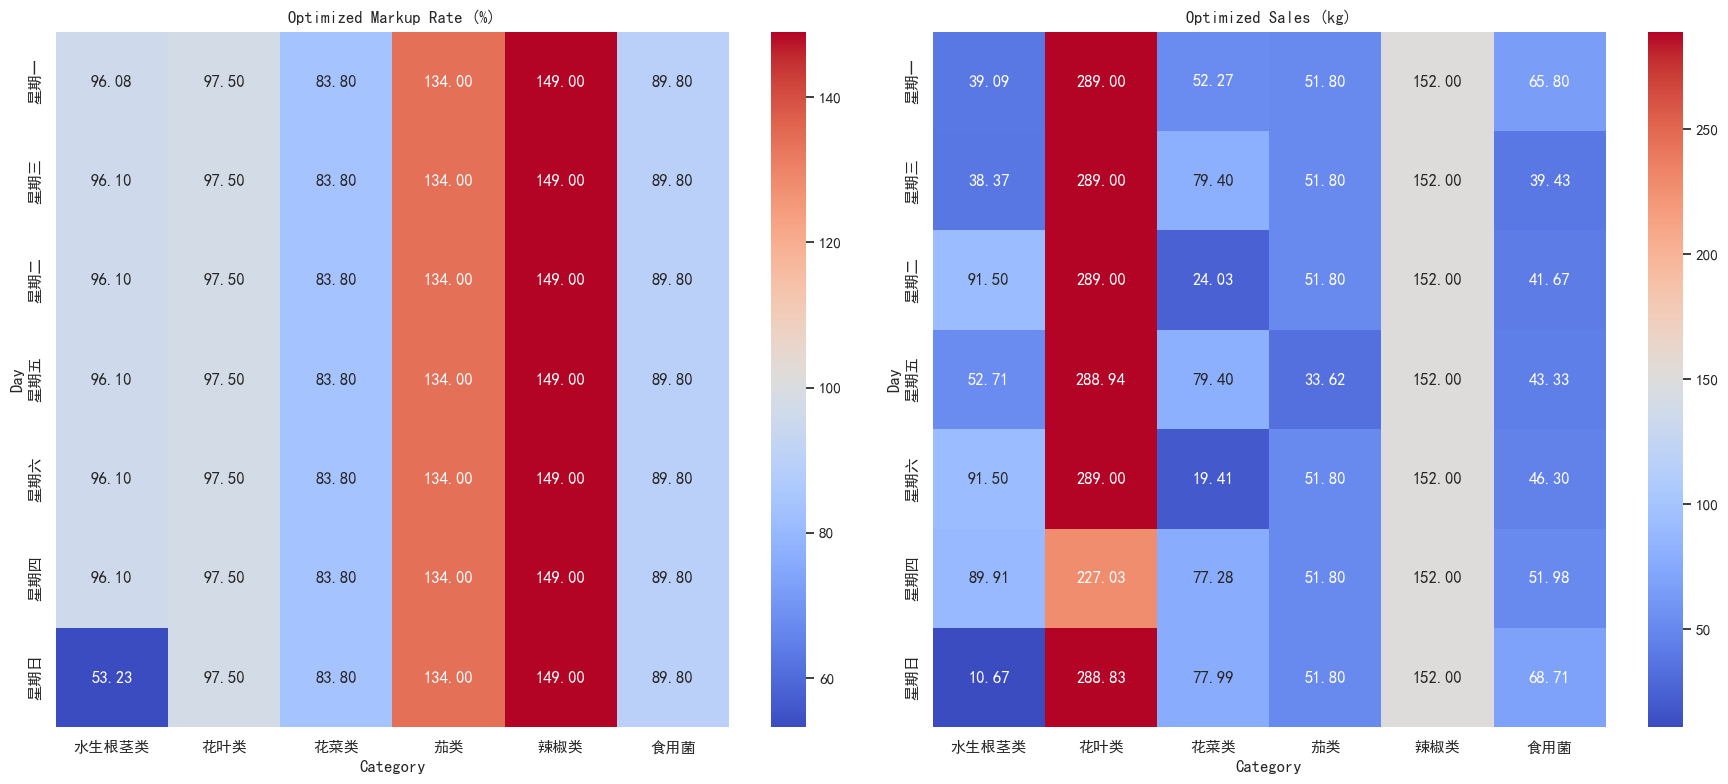

In [16]:
df=final_table
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
plt.rcParams['font.sans-serif'] = ['SimHei']
# Plot for "Optimized Markup Rate (%)"
sns.heatmap(data=df.pivot(index="Day", columns="Category", values="Optimized Markup Rate (%)"), annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
axes[0].set_title('Optimized Markup Rate (%)')

# Plot for "Optimized Sales (kg)"
sns.heatmap(data=df.pivot(index="Day", columns="Category", values="Optimized Sales (kg)"), annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
axes[1].set_title('Optimized Sales (kg)')

plt.tight_layout()
plt.show()
